In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import glob
import json
import csv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext,SparkSession
from pyspark import SparkContext,SparkConf,StorageLevel
from scipy.sparse import csr_matrix
from tqdm import tqdm
from scipy import sparse
import spacy
from spacy.matcher import Matcher
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gc

In [4]:
# Ref: https://www.kaggle.com/maksimeren/covid-19-literature-clustering
file_path = "/media/jayesh/New Volume/Covid_19_dataset/C19data/metadata.csv"
C19_metadata = pd.read_csv(file_path,dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str })
C19_metadata.head()

/usr/local/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [5]:
# Getting the path of json files into a list
path = "/media/jayesh/New Volume/Covid_19_dataset/C19data/"
json_paths = glob.glob(f'{path}/**/*.json',recursive=True)
print(json_paths[:5])
print(len(json_paths))

['/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/0001418189999fea7f7cbe3e82703d71c85a6fe5.json', '/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/0003793cf9e709bc2b9d0c8111186f78fb73fc04.json', '/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/000379d7a7f37a2ccb978862b9f2016bd03259ea.json', '/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/00039b94e6cb7609ecbddee1755314bcfeb77faa.json', '/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/0003ddc51c4291d742855e9ac56076a3bea33ad7.json']
139694


In [6]:
# Reading the data from json files and putting it into a dataframe
covid_data = {'paper_id':[],'title':[],'abstract':[],'text':[]}

for id,each in enumerate(json_paths):
    if (id+1)%3000 == 0:
        print("Completed processing for "+str(id+1)+" files")
    elif (id+1) == 139694:
        print("Processing Completed for all files")
        
    with open(each) as f:
        bodytext = []
        abstract = []
        try:
            content = json.load(f)
            for each_input in content["abstract"]:
                abstract.append(each_input["text"])    
            for each_input in content["body_text"]:
                bodytext.append(each_input["text"])
            bodytext = " ".join(bodytext)
            abstract = " ".join(abstract)
            covid_data['text'].append(bodytext)
            covid_data['abstract'].append(abstract)
            covid_data["paper_id"].append(content["paper_id"])
            covid_data["title"].append(content["metadata"]["title"])
        except:
            continue
#print(data)        

Completed processing for 3000 files
Completed processing for 6000 files
Completed processing for 9000 files
Completed processing for 12000 files
Completed processing for 15000 files
Completed processing for 18000 files
Completed processing for 21000 files
Completed processing for 24000 files
Completed processing for 27000 files
Completed processing for 30000 files
Completed processing for 33000 files
Completed processing for 36000 files
Completed processing for 39000 files
Completed processing for 42000 files
Completed processing for 45000 files
Completed processing for 48000 files
Completed processing for 51000 files
Completed processing for 54000 files
Completed processing for 57000 files
Completed processing for 60000 files
Completed processing for 63000 files
Completed processing for 66000 files
Completed processing for 69000 files
Completed processing for 72000 files
Completed processing for 75000 files
Completed processing for 78000 files
Completed processing for 81000 files
Comp

In [7]:
print(len(covid_data['abstract']))
covid19_df = pd.DataFrame(covid_data)
covid19_df.head()

80744


,paper_id,title,abstract,text
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,,How do we protect our 'high-risk' patient popu...
2,000379d7a7f37a2ccb978862b9f2016bd03259ea,ScienceDirect ScienceDirect Effect of Nanomate...,approach. The NM shape in the conformal circui...,Integration of functional electronic devices o...
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,,It is said that crisis reveals character. The ...


In [8]:
# Treating empty cells
covid19_df['abstract'].replace('',np.nan,inplace=True)
covid19_df['title'].replace('',np.nan,inplace=True)
covid19_df['text'].replace('',np.nan,inplace=True)
covid19_df['paper_id'].replace('',np.nan,inplace=True)
covid19_df.head()
covid19_df.isna().sum()

paper_id        0
title        8527
abstract    25461
text            0
dtype: int64

In [9]:
# Dropping Nan values
covid19_df.dropna(inplace=True)
covid19_df.isna().sum()
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53091 entries, 0 to 80743
Data columns (total 4 columns):
paper_id    53091 non-null object
title       53091 non-null object
abstract    53091 non-null object
text        53091 non-null object
dtypes: object(4)
memory usage: 2.0+ MB


In [10]:
# Identifying the language of the articles/data (only data in english is considered for analysis)
languages = []
remove = []
from langdetect import detect, DetectorFactory
for index in range(len(covid19_df)):
    try:
        DetectorFactory.seed=0
        languages.append(detect(str(covid19_df['text'].iloc[index][:500])))
    except:
        languages.append("unrec")
        remove.append(index)
        pass

In [11]:
covid19_df['language'] = languages

In [12]:
covid19_df.head()

,paper_id,title,abstract,text,language
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,en
2,000379d7a7f37a2ccb978862b9f2016bd03259ea,ScienceDirect ScienceDirect Effect of Nanomate...,approach. The NM shape in the conformal circui...,Integration of functional electronic devices o...,en
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,en
8,00073cb65dd2596249230fab8b15a71c4a135895,Risk Parameters of Fulminant Acute Respiratory...,A clinical picture of patients with acute resp...,"Since then, many clinical case reports have be...",en
10,0008c57de475138d903f2cca7003cf1e1ad93cf4,The effect of gramicidin inclusions on the loc...,We study the local effect of the antimicrobial...,The effect on the cell membrane of inclusions ...,en


In [13]:
covid19_df['language'].value_counts()

en       52192
de         300
fr         231
es         200
nl         101
it          35
pt          11
unrec        5
pl           3
ca           3
cy           3
sv           1
af           1
tl           1
id           1
ko           1
ru           1
zh-cn        1
Name: language, dtype: int64

In [14]:
# Considering only those articles that are in english
covid19_df = covid19_df[covid19_df['language'] == 'en']
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52192 entries, 0 to 80743
Data columns (total 5 columns):
paper_id    52192 non-null object
title       52192 non-null object
abstract    52192 non-null object
text        52192 non-null object
language    52192 non-null object
dtypes: object(5)
memory usage: 2.4+ MB


In [16]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', \
            'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', \
            'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www', 'however', 'therefore', 'since', 'respectively', 'although', 'include', \
            'including', 'example']

In [18]:
# The function performs preprocessing on the data
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in text_data:
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub("[\(\[].*?[\)\]]", "", sent)
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [19]:
# Performing preprocessing on the text column(i.e. actual data)
preprocessed_text = preprocess_text(covid19_df['text'].values)
covid19_df['preprocessed_text'] = preprocessed_text

In [20]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52192 entries, 0 to 80743
Data columns (total 6 columns):
paper_id             52192 non-null object
title                52192 non-null object
abstract             52192 non-null object
text                 52192 non-null object
language             52192 non-null object
preprocessed_text    52192 non-null object
dtypes: object(6)
memory usage: 2.8+ MB


In [44]:
# Saving dataframe to csv to prevent repeated processing
covid19_df.to_csv('preprocessed_covi19_data.csv')

In [2]:
# Reading from csv
covid19_df = pd.read_csv('preprocessed_covi19_data.csv')

In [21]:
#Taking only a subset of data(i.e.10000 research articles) because of memory limitations
covid19_df_subset = covid19_df[:10000] 
covid19_df_subset.info()
c_data = covid19_df_subset['preprocessed_text'].values
print(len(c_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 15571
Data columns (total 6 columns):
paper_id             10000 non-null object
title                10000 non-null object
abstract             10000 non-null object
text                 10000 non-null object
language             10000 non-null object
preprocessed_text    10000 non-null object
dtypes: object(6)
memory usage: 546.9+ KB
10000


In [22]:
c_title = covid19_df_subset['title'].values

In [5]:
# Using TFIDF vectorizer for coverting text to vectors(considering only 10000 features because of memory limitations)
vectorizer_tfidf = TfidfVectorizer(max_features=10000)
vectorizer_tfidf.fit(c_data)
covid_tfidf_text = vectorizer_tfidf.transform(c_data)
print("Data shape:",covid_tfidf_text.shape)

Data shape: (10000, 10000)


In [6]:
# Implementing TFIDF for dimensionality reduction
pca = PCA(n_components=0.99,svd_solver='full',random_state=42)
covid_tfidf_pca= pca.fit_transform(covid_tfidf_text.toarray())
covid_tfidf_pca.shape

(10000, 6202)

In [7]:
# Ref: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

# Finding the optimal values of k using Silhouette Score as a metric
sil_score = []
for k in tqdm(range(2,101)):
    kmeans = KMeans(n_clusters = k).fit(covid_tfidf_pca)
    labels = kmeans.labels_
    sil_score.append(silhouette_score(covid_tfidf_pca, labels, metric = 'euclidean'))    

100%|██████████| 99/99 [12:00:09<00:00, 706.95s/it]  


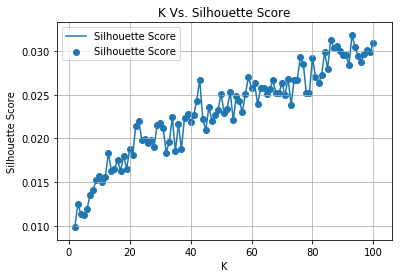

In [8]:
# Plotting the results
plt.plot(range(2,101),sil_score,label="Silhouette Score")
plt.scatter(range(2,101),sil_score,label="Silhouette Score")
plt.title("K Vs. Silhouette Score")
plt.grid()
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [23]:
c_orig_text = covid19_df_subset['text'].values

In [10]:
# Implementing K-means clustering
k = 93 # The optimal value of k (look at the plot)
kmeans = KMeans(n_clusters=k, random_state=2)
y_pred = kmeans.fit_predict(covid_tfidf_pca)

In [16]:
# Creating dataframe containg: Title of research paper,text in research paper, Cluster Number that the paper was assigned to
ypred = list(y_pred)
cluster_df = pd.DataFrame(list(zip(c_title,c_orig_text,ypred)),columns=['Title','Original text','Cluster'])
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
Title            10000 non-null object
Original text    10000 non-null object
Cluster          10000 non-null int64
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [17]:
# Organise the dataframe based on cluster
sort_df_by_cluster = cluster_df.sort_values('Cluster')

In [18]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [33]:
# The function performs preprocessing on the text
def preprocess_text(text_data):
    pre_processed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub("[\(\[].*?[\)\]]", "", sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split())
        pre_processed_text.append(sent.strip())
    return pre_processed_text

In [34]:
# Performing preprocessing on the text column in the dataframe and creating a new column containg preprocessed text
preprocessed_cluster_text = preprocess_text(sort_df_by_cluster['Original text'].values)
sort_df_by_cluster['Clustered_preprocessed_text'] = preprocessed_cluster_text

100%|██████████| 10000/10000 [00:19<00:00, 509.31it/s]


In [35]:
# Save the cluster dataframe to prevent repeated processing
sort_df_by_cluster.to_csv('cluster_ie_df.csv')

In [24]:
# Retrieve from cluster csv file
sort_df_by_cluster = pd.read_csv('cluster_ie_df.csv')
sort_df_by_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
Unnamed: 0                     10000 non-null int64
Title                          10000 non-null object
Original text                  10000 non-null object
Cluster                        10000 non-null int64
Clustered_preprocessed_text    10000 non-null object
dtypes: int64(2), object(3)
memory usage: 390.7+ KB


In [25]:
print(sort_df_by_cluster['Cluster'].value_counts())

18    512
90    501
22    303
63    296
42    252
30    232
39    227
91    225
52    225
25    210
10    208
3     201
38    201
46    194
19    190
53    190
57    186
51    186
15    173
68    173
58    166
65    157
67    156
87    154
6     136
86    133
44    132
34    128
69    127
9     125
     ... 
64     50
79     46
11     44
26     44
12     43
0      41
21     41
59     41
82     39
8      38
45     37
83     37
73     35
50     31
61     31
24     31
37     30
56     29
20     29
72     28
28     28
76     27
32     26
49     24
54     24
33     18
71     18
77     15
85     14
66     13
Name: Cluster, Length: 93, dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

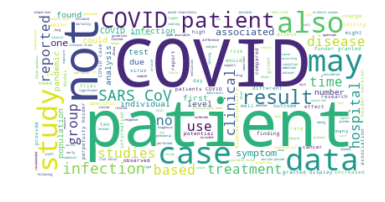

100%|██████████| 1/1 [38:01<00:00, 2281.63s/it]


In [28]:
# Ref: https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

## This code segment implements information extraction and wordcloud for each cluster 
for j in tqdm(range(9,10)):
    sentences = []
    title = []
    sentence_in_vector = []
    ranked_sentences = []
    
# Performing sentence tokenizer to break the text into sentences
    for s in zip(sort_df_by_cluster[sort_df_by_cluster['Cluster']==j]['Clustered_preprocessed_text'].values,sort_df_by_cluster[sort_df_by_cluster['Cluster']==j]['Title'].values):
        t = sent_tokenize(s[0])
        sentences.append(t)
        for i in range(len(t)):
            title.append(s[1])
    sentences = [y for x in sentences for y in x] # flatten list
    
# Creating a dataframe that contains sentence('Sentence') and research paper that the sentence belongs to('Title').    
    sent_df = pd.DataFrame({'Title': title,'Sentence': sentences})
    lst = sent_df['Sentence'].tolist()
    #sent_df['Useful'] = sent_df['Sentence'].apply(find_useful)--------> this is original

# Using Spark to speed up the calculations   
    sc = SparkSession.builder.master("local[*]").appName("spark session example").config("spark.driver.memory", "2g").config("spark.executor.memory", "2g").getOrCreate()
    rdd  = sc.sparkContext.parallelize(lst)
    result = rdd.map(lambda each:find_useful(each)) 
    flag_list = result.collect()  # Collect result from rdd(i.e. flag values which implies whether sentence contains any pattern or not)
    
# Adding flag list to the dataframe to identify the sentence that contains matched patterns(look at function find_useful())    
    sent_df["Useful"] = flag_list
    sent_useful = sent_df[sent_df['Useful'] == 1] # Retrieving rows from the datframe that contain sentences with useful information
    
    filename = "/home/jayesh/Documents/results/Cluster_{}_IE.csv".format(j) # Path to save dataframe
    wcfn = "/home/jayesh/Documents/results/Cluster_{}_WC.png".format(j)     # Path to save wordcloud
    sent_useful.to_csv(filename)
    del [[sent_df,sent_useful]]
    gc.collect()
    sent_df = pd.DataFrame()
    sent_useful = pd.DataFrame()
    
# Implementing WordCloud    
    text = " ".join(each for each in sort_df_by_cluster[sort_df_by_cluster["Cluster"]==j]["Clustered_preprocessed_text"].values)    
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file(wcfn)
    
# The output shows result of one cluster    

In [26]:
# Ref: https://www.analyticsvidhya.com/blog/2020/06/nlp-project-information-extraction/

# The function matches the patterns in the text and return a flag value of 1 if match is found else 0
def find_useful(text):
            
    nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])
    
    # spacy doc
    doc = nlp(text)
    
    # patterns
    p1 = [{'LOWER':'transmission'},{'LOWER':'period'}]
    p2 = [{'LOWER':'incubation'},{'LOWER':'period'}]
    p3 = [{'LOWER':'season'},{'LOWER':'of','OP':'?'},{'POS':'PROPN','OP':'?'}]
    p4 = [{'LOWER':'coronavirus'}]
    p5 = [{'LOWER':'environmental'},{'LOWER':'survival'}]
    p6 = [{'LOWER':'persistence'}]
    p7 = [{'LOWER':'phenotypic'},{'LOWER':'change','OP':'?'}]
    p8 = [{'LOWER':'immune'},{'LOWER':'response','OP':'?'}]
    p9 = [{'LOWER':'prevent'},{'LOWER':'transmission'}]
    p10 = [{'LOWER':'role'},{'LOWER':'of','OP':'?'},{'POS':'PROPN'}]
    p11 = [{'LOWER':'prevalence'},{'LOWER':'of'},{'POS':'PROPN'}]
    p12 = [{'LOWER':'persistence'},{'LOWER':'of'},{'POS':'PROPN'}]
    p13 = [{'LOWER':'sars-cov-2'}]
    p14 = [{'LOWER':'animal'},{'LOWER':'host'}]
    p15 = [{'LOWER':'effectiveness'},{'LOWER':'of'},{'POS':'PROPN'}]
    p16 = [{'LOWER':'coronavirus'},{'LOWER':'in'},{'POS':'human'}]
    p17 = [{'LOWER':'sars'}]
    p18 = [{'LOWER':'cov'}]
    p19 = [{'LOWER':'clinical'},{'LOWER':'trials'}]
    p20 = [{'LOWER':'medications'}]
    p21 = [{'LOWER':'human'},{'LOWER':'host'}]
    p22 = [{'LOWER':'human'}]
    
    # Matcher class object 
    matcher = Matcher(nlp.vocab) 
    matcher.add("names", None, p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22) 

    matches = matcher(doc)
    
    # If atleast one pattern matches return 1 else 0
    if len(matches) > 0:
        flag = 1
    else:
        flag = 0
        
    return flag      
